In [1]:
%matplotlib inline

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import numpy as np, cmath,scipy as sp
import scipy.io
from matplotlib import pyplot as plt

from numpy import pi, sin, cos, exp, sqrt, log,log10, random, convolve#import basic functions from numpy that we'll need
from numpy.fft import fft, ifft
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

eeg = scipy.io.loadmat('sub13_eeg_sleepstage_data.mat')

import pandas as pd
eegdata=pd.DataFrame()
eegdata['ch1'] = np.squeeze(eeg["eeg_data"][:,1:2])
eegdata['ch2'] = np.squeeze(eeg["eeg_data"][:,2:3])
eegdata['ch3'] = np.squeeze(eeg["eeg_data"][:,3:4])
eegdata['ch4'] = np.squeeze(eeg["eeg_data"][:,4:5])
eegdata['ch5'] = np.squeeze(eeg["eeg_data"][:,5:6])
eegdata['ch6'] = np.squeeze(eeg["eeg_data"][:,6:7])
eegdata['stage'] = np.squeeze(eeg["eeg_data"][:,7:8])

X = eegdata.ix[:,0:6].values
y = eegdata.ix[:,6].values

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [2]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])
    
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['CH %s' %i for i in range(1,7)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['CH %s' %i for i in range(1,7)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Variance in percent'),
        title='Variance by different principal components')

fig = Figure(data=data, layout=layout)
py.iplot(fig)

Eigenvectors 
[[ 0.42483442  0.37485884  0.41156153 -0.16990413  0.68224003 -0.12367213]
 [ 0.43049776  0.35942972  0.3858865  -0.11003732 -0.68118056  0.2458829 ]
 [ 0.43671974  0.14793151 -0.47042238  0.06449574 -0.18506546 -0.72641999]
 [ 0.42555915  0.11396527 -0.54449398  0.31567678  0.1902629   0.61121668]
 [ 0.36911244 -0.5916802  -0.11337832 -0.69896298  0.00958065  0.11033983]
 [ 0.35513193 -0.58765113  0.38869416  0.60552754 -0.00077455 -0.10392355]]

Eigenvalues 
[ 4.12497529  0.86572816  0.56091732  0.25822837  0.06327359  0.12687809]
Eigenvalues in descending order:
4.12497528993
0.865728160835
0.56091732344
0.258228374368
0.126878092879
0.0632735914359


In [4]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(6,1),
                     (eig_pairs[1][1].reshape(6,1))))

print('Matrix W:\n', matrix_w)

Y = X_std.dot(matrix_w)
Y

Matrix W:
 [[ 0.42483442  0.37485884]
 [ 0.43049776  0.35942972]
 [ 0.43671974  0.14793151]
 [ 0.42555915  0.11396527]
 [ 0.36911244 -0.5916802 ]
 [ 0.35513193 -0.58765113]]


array([[ 0.84349305, -2.75392339],
       [ 0.84349305, -2.75392339],
       [ 2.79072735, -2.92856237],
       ..., 
       [ 0.11231292, -0.01509847],
       [ 0.11231292, -0.01509847],
       [ 0.07478933, -0.04997599]])

In [4]:
traces = []
len(Y)
for stage in (1, 0, -1,-2,-3,-4,-5):

    trace = Scatter(
        x=Y[y==stage,0][:500],
        y=Y[y==stage,1][:500],
        mode='markers',
        name=stage,
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(showlegend=True,
                scene=Scene(xaxis=XAxis(title='PC1'),
                yaxis=YAxis(title='PC2'),))

fig = Figure(data=data, layout=layout)
py.iplot(fig)

In [6]:
custom_eeg_data = pd.DataFrame()
custom_eeg_data['pca']=np.squeeze(Y[:,1])
custom_eeg_data['stage']=np.round(np.squeeze(eeg["eeg_data"][:,7:8]))
custom_eeg_data
custom_eeg_data['stage'].value_counts()

-2.0    2375229
-1.0    2157673
 1.0    1976131
-5.0     303523
-3.0     255806
 0.0     133029
-4.0       2448
Name: stage, dtype: int64

In [7]:
custom_eeg_data =custom_eeg_data.loc[(custom_eeg_data['stage']==0) | (custom_eeg_data['stage']==1) | (custom_eeg_data['stage']==-1) | 
                                     (custom_eeg_data['stage']==-2) | (custom_eeg_data['stage']==-3) | (custom_eeg_data['stage']==-4) |
                                     (custom_eeg_data['stage']==-5)]
custom_eeg_data
df1 = custom_eeg_data.loc[custom_eeg_data['stage']==1]
df1 = df1[:20000]
df0 = custom_eeg_data.loc[custom_eeg_data['stage']==0]
df0 = df0[:20000]
dfm1 = custom_eeg_data.loc[custom_eeg_data['stage']==-1]
dfm1 = dfm1[:20000]
dfm2 = custom_eeg_data.loc[custom_eeg_data['stage']==-2]
dfm2 = dfm2[:20000]
dfm3 = custom_eeg_data.loc[custom_eeg_data['stage']==-3]
dfm3 = dfm3[:20000]
dfm4 = custom_eeg_data.loc[custom_eeg_data['stage']==-4]
dfm4 = dfm4[:20000]
dfm5 = custom_eeg_data.loc[custom_eeg_data['stage']==-5]
dfm5 = dfm5[:20000]
main=df1.append(df0).append(dfm1).append(dfm2).append(dfm3).append(dfm4).append(dfm5)
main = main.astype(float).fillna(main.mean())
main['stage'].value_counts()


final=pd.DataFrame()
final['pca']=main['pca']
final['stage']=main['stage']

In [44]:
custom_eeg_data =custom_eeg_data.loc[(custom_eeg_data['stage']==0) | (custom_eeg_data['stage']==1) | (custom_eeg_data['stage']==-1) | 
                                     (custom_eeg_data['stage']==-2) | (custom_eeg_data['stage']==-3) | (custom_eeg_data['stage']==-4) |
                                     (custom_eeg_data['stage']==-5)]
custom_eeg_data
df1 = custom_eeg_data.loc[custom_eeg_data['stage']==1]
df1 = df1[:20000]
df0 = custom_eeg_data.loc[custom_eeg_data['stage']==0]
df0 = df0[:20000]
dfm1 = custom_eeg_data.loc[custom_eeg_data['stage']==-1]
dfm1 = dfm1[:20000]
dfm2 = custom_eeg_data.loc[custom_eeg_data['stage']==-2]
dfm2 = dfm2[:20000]
dfm3 = custom_eeg_data.loc[custom_eeg_data['stage']==-3]
dfm3 = dfm3[:20000]
dfm5 = custom_eeg_data.loc[custom_eeg_data['stage']==-5]
dfm5 = dfm5[:20000]
main=df1.append(df0)
main = main.astype(float).fillna(main.mean())
main['stage'].value_counts()


final=pd.DataFrame()
final['pca']=main['pca']
final['stage']=main['stage']
main['stage'].value_counts()

0.0    20000
1.0    20000
Name: stage, dtype: int64

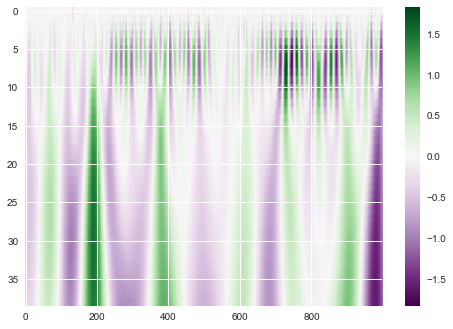

In [19]:
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = main['pca']
widths1 = np.arange(1,40)
cwtmatr1 = signal.cwt(sig[1:1000], signal.ricker, widths1)
im=plt.imshow(cwtmatr1, cmap='PRGn', aspect='auto',vmax=abs(cwtmatr1).max(), vmin=-abs(cwtmatr1).max())
plt.colorbar(im)
plt.show()

In [17]:
def plot_fun(sig):
    plt.plot(sig[1:1000])
    plt.show()

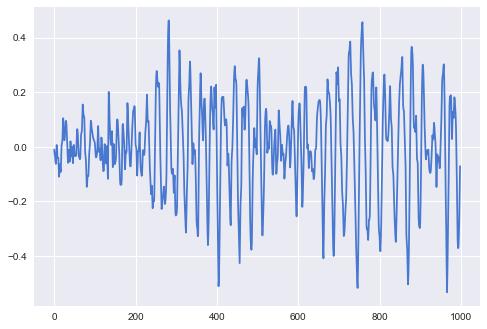

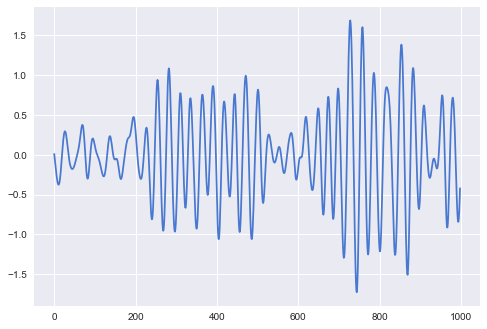

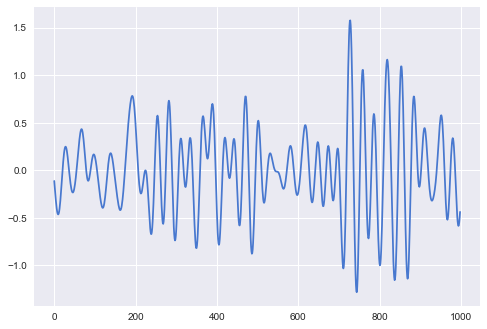

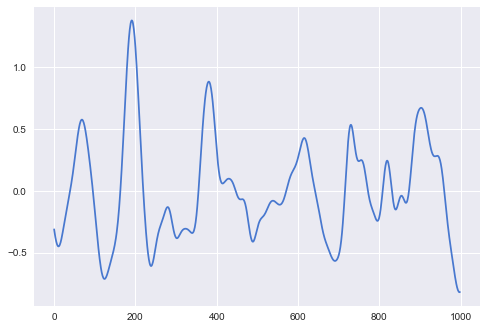

In [18]:
delta=np.mean(cwtmatr1[0:4],axis=0)
theta=np.mean(cwtmatr1[5:8],axis=0)
alpha=np.mean(cwtmatr1[8:12],axis=0)
beta=np.mean(cwtmatr1[12:35],axis=0)
plot_fun(delta)
plot_fun(theta)
plot_fun(alpha)
plot_fun(beta)

In [48]:
import pandas as pd
data=pd.DataFrame()
delta=np.mean(cwtmatr1[0:4],axis=0)
theta=np.mean(cwtmatr1[5:8],axis=0)
alpha=np.mean(cwtmatr1[8:12],axis=0)
beta=np.mean(cwtmatr1[12:35],axis=0)
main['alpha']=alpha
main['beta']=beta
main['delta']=delta
main['theta']=theta
main.head()

,pca,stage,alpha,beta,delta,theta
122752,-0.083165,1.0,-0.061114,-0.288412,0.029730,0.054253
122753,-0.083165,1.0,-0.113436,-0.311923,-0.010910,0.009674
122754,-0.092115,1.0,-0.166980,-0.334301,-0.026620,-0.038508
122755,-0.092115,1.0,-0.220323,-0.355295,-0.035942,-0.088563
122756,-0.155666,1.0,-0.271949,-0.374668,-0.055139,-0.138784


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(main.iloc[:,2:6], main.iloc[:,1], test_size=.4, random_state=42)

In [50]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.72531250000000003

In [51]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(3)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.82643750000000005

In [52]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.77587499999999998

In [54]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
score

0.77275000000000005